# Masterclass Unsupervised analysis
## Hands on session 3 - Clustering algorithms
#### IenW | Data en Innovatielab | Oct 2024

## Cluster validation/ automated Cut-Off Selection
There is <b><u>NO</u></b> golden method to define the optimal number of clusters. It requires investigation, and backtesting.

There are a couple of common methods. Best practices are:
<br>
<b>1. Inconsistency method</b>
<br>
<b>2. DAVIES BOULDIN index</b>
<br>
<b>3. SILHOUTTE Scores</b>


These methods works pretty well in some scenarios but it heavily depends on the type of data that you are using.


The <b>"inconsistency" method</b>, is one of the defaults for the fcluster() function in scipy.
It compares each cluster merge's height h to the average avg and normalizing it by the standard deviation std formed over the depth previous levels:


In [ ]:
!pip install scatterd
!pip install clusteval
!pip install d3blocks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.5
    Uninstalling MarkupSafe-2.1.5:
      Successfully uninstalled MarkupSafe-2.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
werkzeug 3.0.4 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [ ]:
# Libraries
import sys, os
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.datasets import make_blobs, make_circles
from scipy.cluster.hierarchy import inconsistent

import numpy as np
import matplotlib.pyplot as plt

from clusteval import clusteval
from scatterd import scatterd

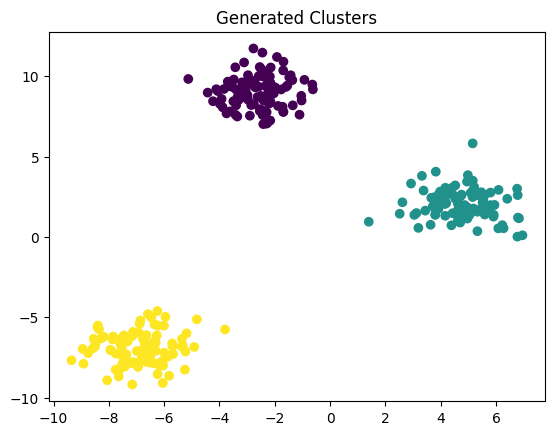

Cluster 0 - S0: 1.1904196228868629
Cluster 1 - S1: 1.1995386639796382
Cluster 2 - S2: 1.2718447357788203
[[ 0.         10.19470965 16.58162892]
 [10.19470965  0.         14.70312974]
 [16.58162892 14.70312974  0.        ]]
Distance between Cluster 0 and Cluster 1: 10.19470964602428
Distance between Cluster 0 and Cluster 2: 16.581628924462866
Distance between Cluster 1 and Cluster 2: 14.703129741613946
Ratio of spread between Cluster 0 and Cluster 1: 0.234431226572356
Ratio of spread between Cluster 0 and Cluster 2: 0.1484935147133287
Ratio of spread between Cluster 1 and Cluster 2: 0.16808553302524132
Worst-case R_i values: [0.23443123 0.23443123 0.16808553]
Davies-Bouldin Index: 0.21231599538998444


In [1]:

########################################################################
# Davies-Bouldin index Example
########################################################################

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances


# Generate data with 3 clusters
n_samples = 300
X, y = make_blobs(n_samples=n_samples, centers=3, cluster_std=1.0, random_state=42)
# X, y = make_blobs(n_samples=n_samples, centers=3, cluster_std=5, random_state=42)

# Visualize the clusters
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o')
plt.title('Generated Clusters')
plt.show()

# Returning X and y for further steps
X[:10], y[:10]  # Display first 10 samples of X and y for verification

##########################################################################
# Step 1: Find the tightness of each cluster (within-cluster scatter, Si)
# We'll start by calculating the spread (tightness) of each cluster. ​​
##########################################################################
def calculate_tightness(X, labels):
    tightness = []
    for label in np.unique(labels):
        cluster_points = X[labels == label]
        center = np.mean(cluster_points, axis=0)

        # Calculate the average distance from center to all points in the cluster
        distances = np.linalg.norm(cluster_points - center, axis=1)
        S_i = np.mean(distances)
        tightness.append(S_i)
    return np.array(tightness)

# Calculate tightness for each cluster
tightness = calculate_tightness(X, y)

# The tightness (within-cluster scatter) of the three clusters are:
print(f'Cluster 0 - S0: {tightness[0]}')
print(f'Cluster 1 - S1: {tightness[1]}')
print(f'Cluster 2 - S2: {tightness[2]}')

##########################################################################
# Step 2: Calculate the distance between each pair of clusters (inter-cluster distance, d(i,j)
# The distances between the centers of the clusters are as follows:
##########################################################################
def calculate_intercluster_distances(X, labels):
    centers = []
    for cluster in np.unique(labels):
        cluster_points = X[labels == cluster]
        center = np.mean(cluster_points, axis=0)
        centers.append(center)

    centers = np.array(centers)
    # Calculate distances between each pair of centers
    intercluster_distances = pairwise_distances(centers)
    return intercluster_distances

# Calculate inter-cluster distances
intercluster_distances = calculate_intercluster_distances(X, y)
print(intercluster_distances)
print(f'Distance between Cluster 0 and Cluster 1: {intercluster_distances[0, 1]}')
print(f'Distance between Cluster 0 and Cluster 2: {intercluster_distances[0, 2]}')
print(f'Distance between Cluster 1 and Cluster 2: {intercluster_distances[1, 2]}')


################################################################################################
# Step 3: Compute the R_ij values for each pair of clusters
# The ratio of the sum of spreads to the distance between clusters. ​​
################################################################################################

def calculate_Rij(tightness, intercluster_distances):
    num_clusters = len(tightness)
    R = np.zeros((num_clusters, num_clusters))
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                R[i, j] = (tightness[i] + tightness[j]) / intercluster_distances[i, j]
    return R

# Calculate R_ij values
R = calculate_Rij(tightness, intercluster_distances)
R

print(f'Ratio of spread between Cluster 0 and Cluster 1: {R[0, 1]}')
print(f'Ratio of spread between Cluster 0 and Cluster 2: {R[0, 2]}')
print(f'Ratio of spread between Cluster 1 and Cluster 2: {R[1, 2]}')

###################################################
# Step 4: Find the worst-case 𝑅i for each cluster.
###################################################
def calculate_Ri(R):
    # For each cluster, find the maximum R_ij (worst-case separation)
    Ri = np.max(R, axis=1)
    return Ri

# Calculate R_i for each cluster
Ri = calculate_Ri(R)
print("Worst-case R_i values:", Ri)

###################################################
# Step 5: Calculate the Davies-Bouldin Index (DB)
###################################################
def calculate_davies_bouldin_index(Ri):
    # Take the average of the worst-case R_i values
    DB_index = np.mean(Ri)
    return DB_index

# Calculate Davies-Bouldin Index
DB_index = calculate_davies_bouldin_index(Ri)
print("Davies-Bouldin Index:", DB_index)



### EXERCISE 10
Evaluate the optimal number of clusters using the Inconsistency method on the messy dataset using hierarchical clustering with complete linkage.

In [ ]:
X, labx = make_blobs(n_samples=750, centers=[[1, 1], [-1, -1], [1, -1], [-1, 1]], cluster_std=0.4,random_state=0)
#X, labx = make_blobs(n_samples=750, centers=5, n_features=2, cluster_std=0.4)

# Cluster
Z=linkage(X, method='ward', metric='euclidean')

depth = 5
incons = inconsistent(Z, depth)

#The following shows a matrix of the avg, std, count, inconsistency for each of the last 10 merges of our hierarchical clustering with depth = 5
#Note that the inconsistency values heavily depend on the depth of the tree you calculate the averages over!
incons[-10:]


array([[ 0.85186046,  1.02756479, 28.        ,  4.09819801],
       [ 1.31269064,  1.33740713, 30.        ,  3.02960375],
       [ 0.95150598,  1.11458241, 30.        ,  4.02246963],
       [ 1.27875311,  1.37003542, 28.        ,  3.13461952],
       [ 0.87295512,  1.10375267, 31.        ,  4.26544137],
       [ 1.43067345,  1.38625174, 30.        ,  3.16700071],
       [ 1.37022723,  1.43146416, 31.        ,  3.53564721],
       [ 2.95784943,  4.67997263, 31.        ,  5.10062239],
       [ 2.91793505,  5.0064487 , 31.        ,  5.10653765],
       [ 5.96338182,  8.83746664, 31.        ,  3.78445263]])

[clustimage] >INFO> Add transparency to RGB colors (last column)
[clusteval] >INFO> Add transparency to RGB colors (last column)
[clusteval] >INFO> Add density layer
[clusteval] >INFO> Create scatterplot


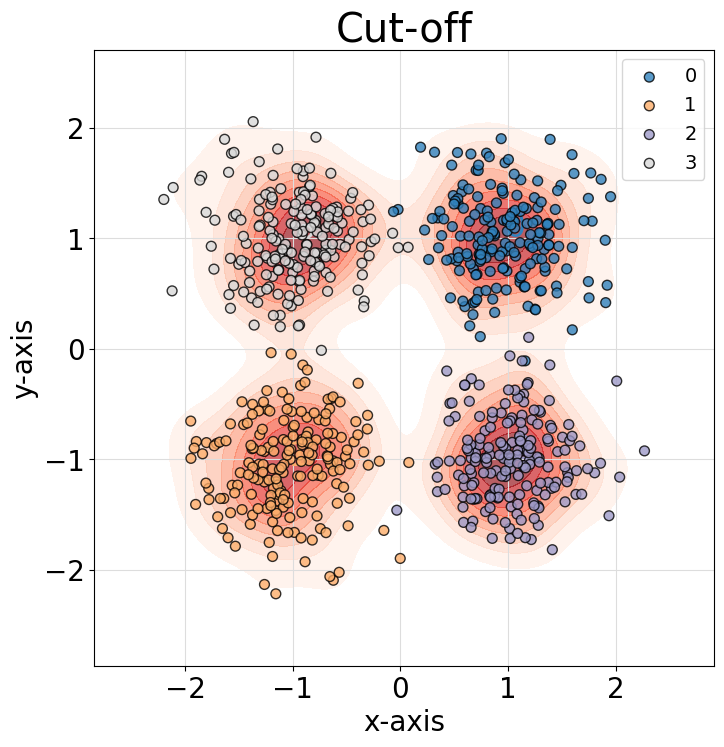

In [ ]:
# scatter plot
fig, ax = scatterd(X[:,0],
                   X[:,1],
                   s=50,
                   labels=labx,
                   density=True,
                   gradient=None, #'#ffffff'
                   title='Cut-off',
                   figsize=(8, 8),
                   )

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate clustering using [derivatives] method
[clusteval] >INFO> Clusters: 4
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [3].
[clusteval] >INFO> Fin.


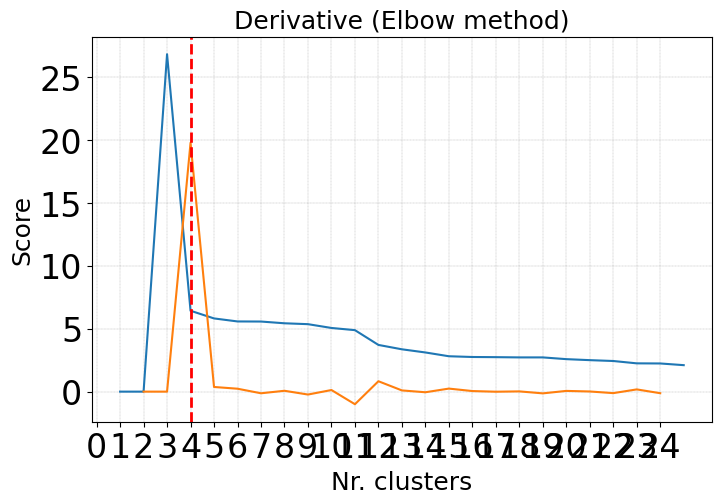

In [ ]:
# Cluster evaluation with the elbow method
cl = clusteval(evaluate='derivative', linkage='ward', metric='euclidean')
cl_results=cl.fit(X)
ax = cl.plot(figsize=(8,5))

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 29.56it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [4].
[clusteval] >INFO> Fin.


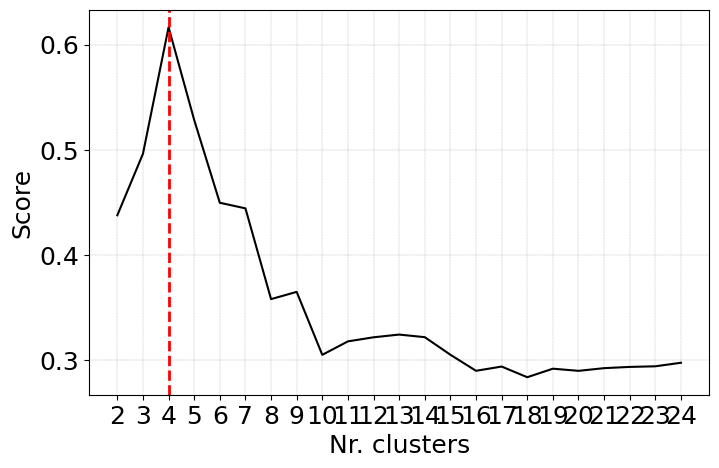

(<Figure size 800x500 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [ ]:
# Cluster evaluation with silhouette score
cl = clusteval(evaluate='silhouette', linkage='ward', metric='euclidean')
cl_results=cl.fit(X)
cl.plot(figsize=(8,5))

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using dbindex.
[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 53.41it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [24].
[clusteval] >INFO> Fin.


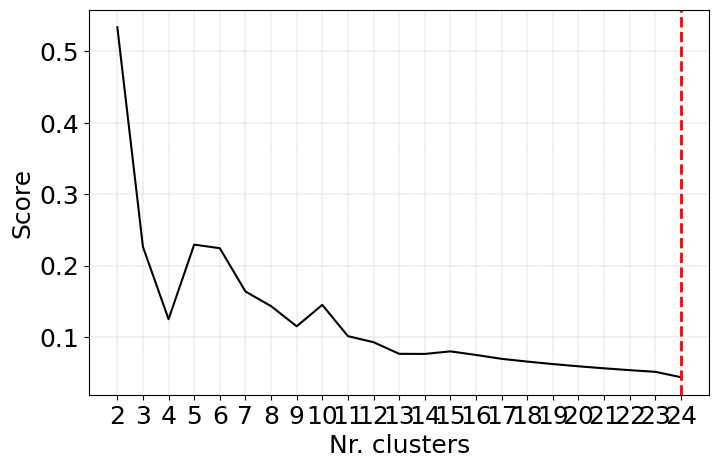

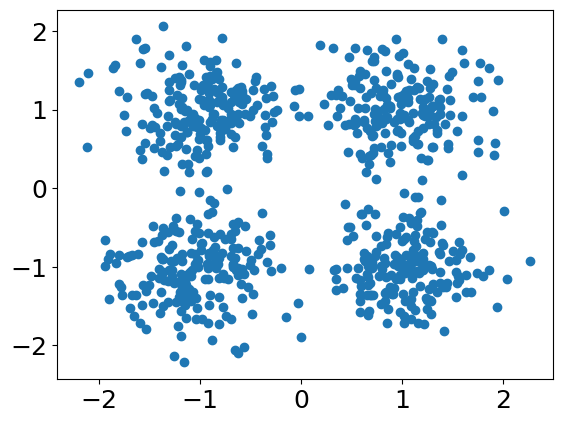

In [ ]:
# Cluster evaluation with silhouette score
cl = clusteval(evaluate='dbindex', linkage='ward', metric='euclidean')
cl_results=cl.fit(X)
cl.plot(figsize=(8,5))
#cl.scatter(X)
plt.scatter(X[:,0], X[:,1])

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[dbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Gridsearch across Epsilon.
[clusteval] >INFO> Evaluate using silhouette..
[clusteval] >INFO: 100%|██████████| 245/245 [00:07<00:00, 34.32it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [5].
[clusteval] >INFO> Fin.


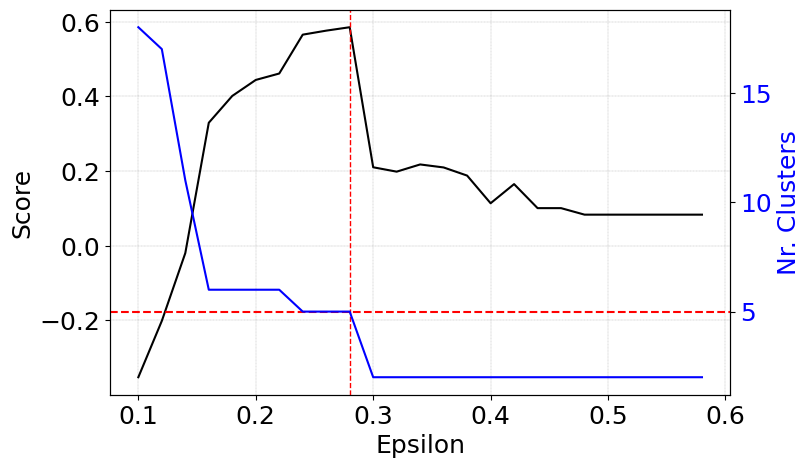

[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Create scatterplot


(<Figure size 1000x800 with 1 Axes>, <Axes: xlabel='x-axis', ylabel='y-axis'>)

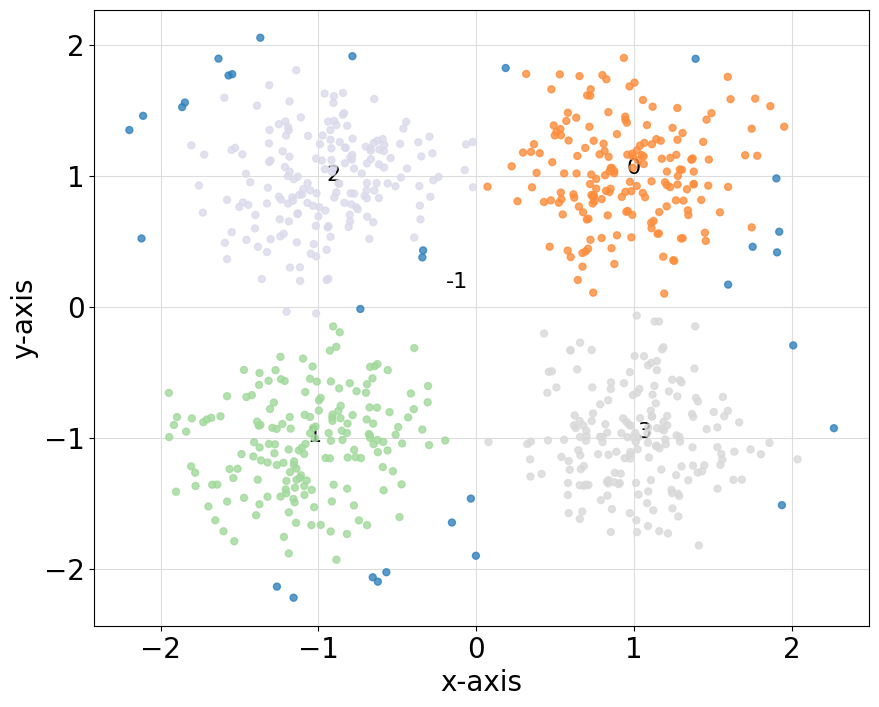

In [ ]:
# Cluster evaluation with silhouette score
cl = clusteval(cluster='dbscan', evaluate='silhouette', linkage='ward', metric='euclidean')
cl_results=cl.fit(X)
cl.plot(figsize=(8,5))
cl.scatter(X, figsize=(10, 8))


[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Create scatterplot


(<Figure size 1000x800 with 1 Axes>, <Axes: xlabel='x-axis', ylabel='y-axis'>)

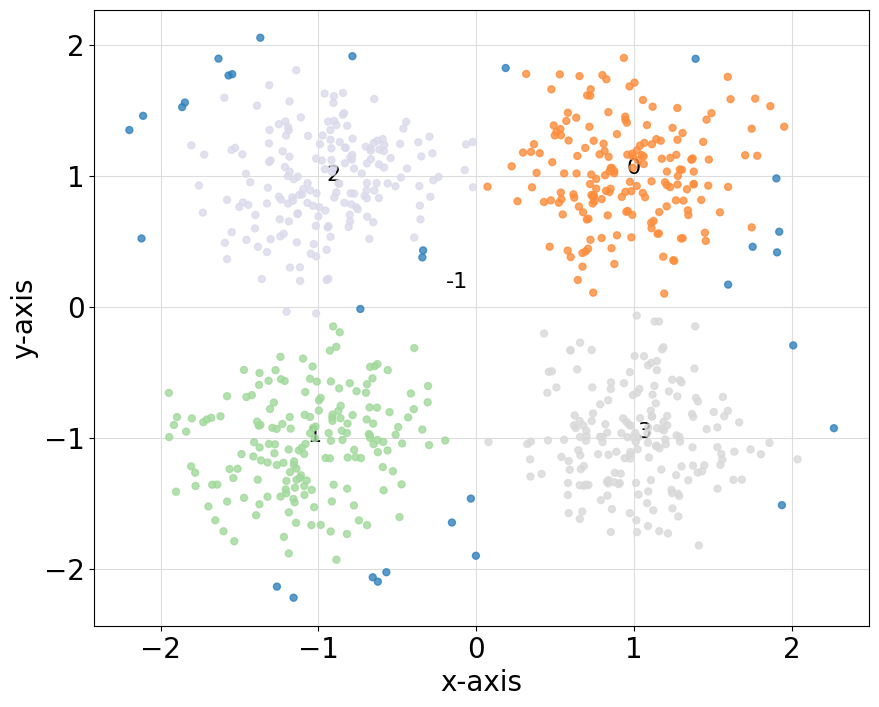

In [ ]:
cl.scatter(X, figsize=(10, 8))

### EXERCISE 11
Evaluate the optimal number of clusters when there is <b>very</b> different variances in the different clusters:

[clustimage] >INFO> Add transparency to RGB colors (last column)
[clusteval] >INFO> Add transparency to RGB colors (last column)
[clusteval] >INFO> Add density layer
[clusteval] >INFO> Create scatterplot


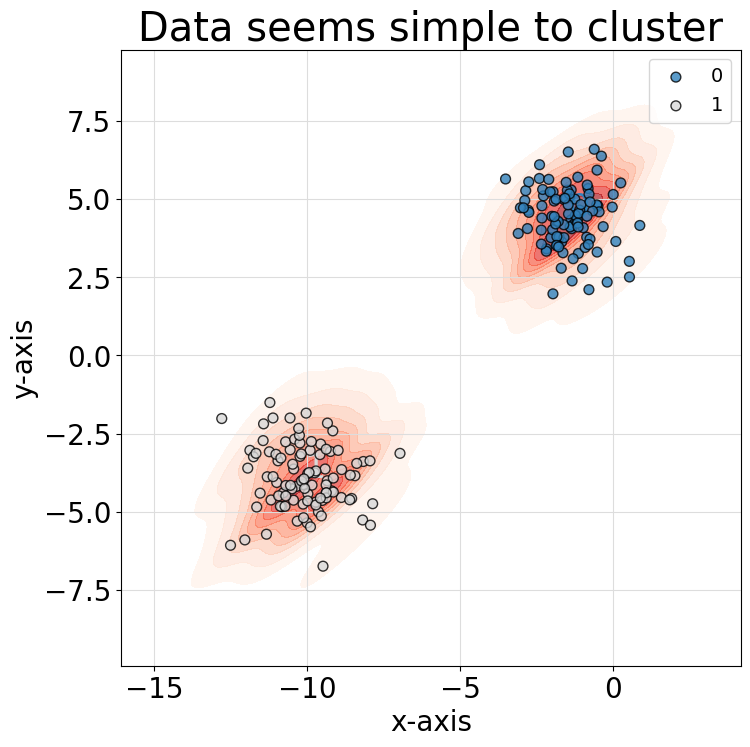

In [ ]:
# Make blobs with variances being extremely different
X, labx = make_blobs(n_samples=200, n_features=2, centers=2, random_state=1)
c = np.random.multivariate_normal([40, 40], [[20, 1], [1, 30]], size=[200,])
d = np.random.multivariate_normal([80, 80], [[30, 1], [1, 30]], size=[200,])
e = np.random.multivariate_normal([0, 100], [[200, 1], [1, 100]], size=[200,])
X2 = np.concatenate((X, c, d, e))


fig, ax = scatterd(X[:,0],
                   X[:,1],
                   s=50,
                   labels=labx,
                   density=True,
                   gradient=None, #'#ffffff'
                   title='Data seems simple to cluster',
                   figsize=(8, 8),
                   )


In [ ]:
len(cl.results['labx'])

750

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate clustering using [derivatives] method
[clusteval] >INFO> Clusters: 4
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [4].
[clusteval] >INFO> Fin.


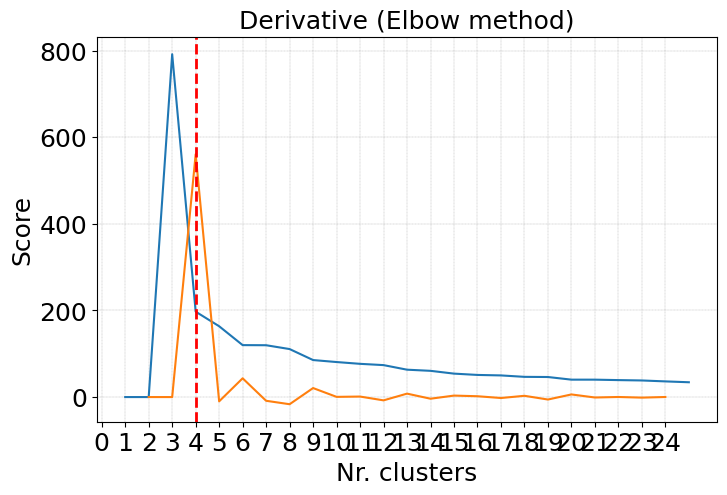

[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Create scatterplot
[clustimage] >INFO> Add transparency to RGB colors (last column)
[clusteval] >INFO> Add transparency to RGB colors (last column)
[clusteval] >INFO> Add density layer
[clusteval] >INFO> Create scatterplot


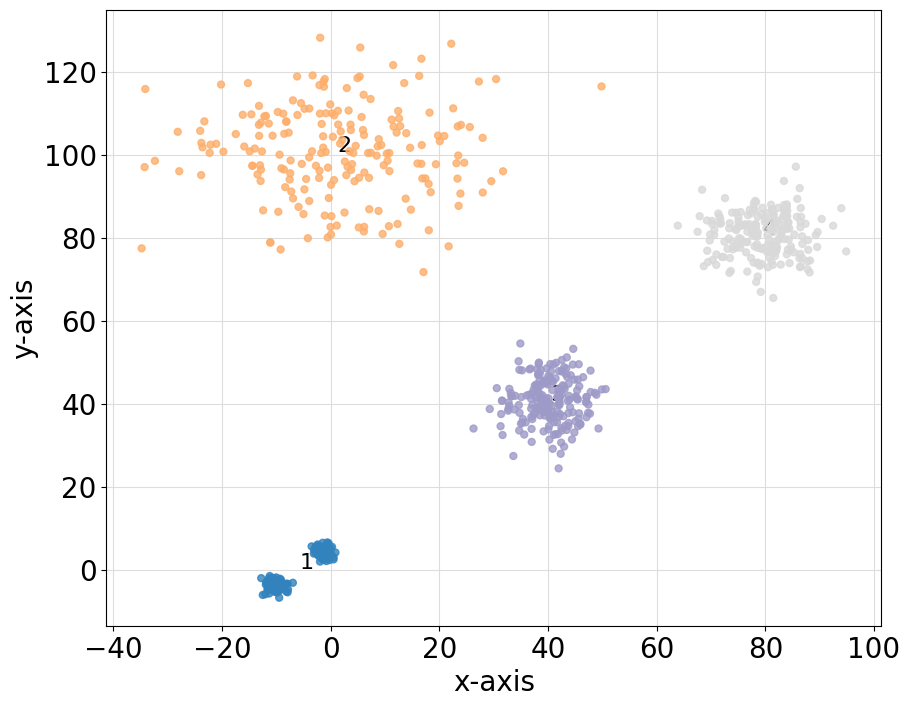

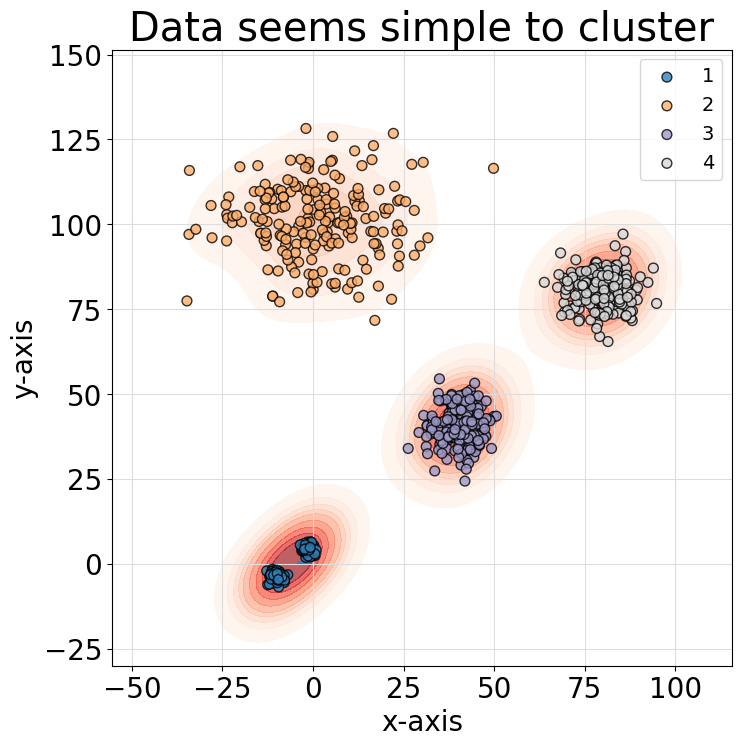

In [ ]:
# Cluster evaluation with silhouette score
cl = clusteval(evaluate='derivative', linkage='ward', metric='euclidean')
# cl = clusteval(evaluate='silhouette', linkage='ward', metric='euclidean')
# cl = clusteval(evaluate='dbindex', linkage='ward', metric='euclidean', max_clust=10)

cl_results=cl.fit(X2)
cl.plot(figsize=(8,5))

# scatter plot
cl.scatter(X2, figsize=(10, 8))

fig, ax = scatterd(X2[:,0],
        X2[:,1],
        s=50,
        labels=cl.results['labx'],
        density=True,
        gradient=None, #'#ffffff'
        title='Data seems simple to cluster',
        figsize=(8, 8),
        )


[clusteval] >INFO> Retrieving input data set.
[clusteval] >INFO> Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=494.698. Be patient now..
[clusteval] >INFO> Compute cluster labels.


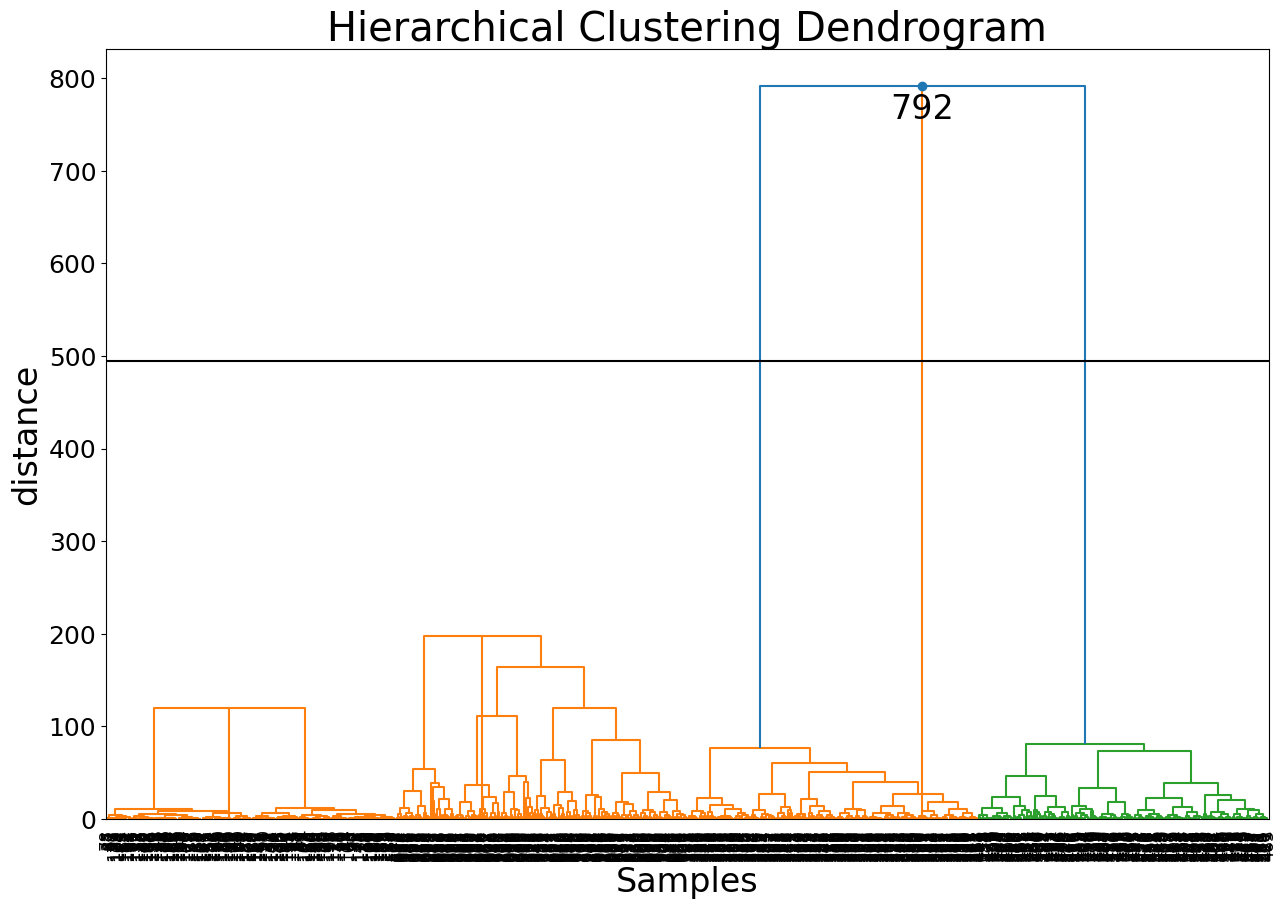

In [ ]:
cl.dendrogram();


#### Explore what exactly happens in the dendrogram when number of samples and variances differ across clusters:
Try to set depth at 60 and 80

In [ ]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

def dendrogram_fancy(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

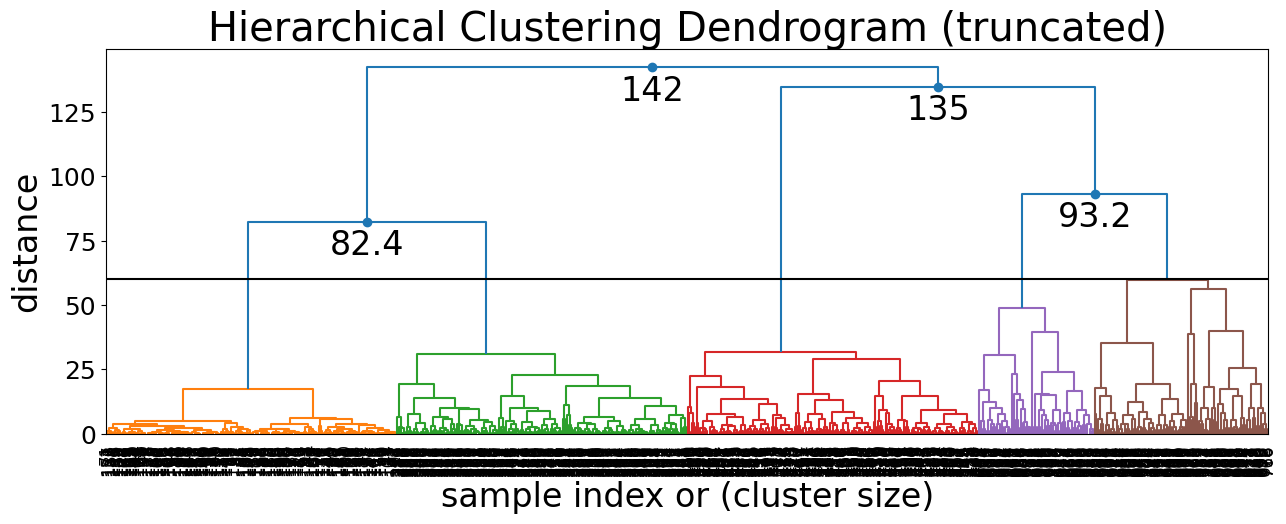

In [ ]:
# Create Dendrogram
Z=linkage(X2, method='complete', metric='euclidean')
#max_d=80
max_d=60

plt.figure(figsize=(15, 5))
out=dendrogram_fancy(Z, leaf_rotation=90, leaf_font_size=12, show_contracted=True, annotate_above=max_d, max_d=max_d)

#out['color_list']
#out['leaves']

# labxNew = fcluster(Z, max_d, criterion='distance')
# tmp=scatter(X2[out['leaves'],0], X2[out['leaves'],1], width=6, height=6, labx=labxNew[out['leaves']], colors=out['color_list'], labx_type='unique', title='Data seems simple to cluster')


### EXERCISE 12
There is <b>NO</b> horizontal cut that gives the optimum number of clusters. How would you proceed now?

### DBSCAN

<br>1.The DBSCAN algorithm views clusters as areas of high density separated by areas of low density.
<br>2. Clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped.
<br>3. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density.
<br>4. A cluster is therefore a set of <b>core</b> samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples).
<br>5. The DBSCAN algorithm is deterministic, always generating the same clusters when given the same data in the same order.

<br>There are two parameters to the algorithm how <b>we</b> define <b>dense</b>
    * min_samples
    * eps
As an example, higher min_samples or lower eps indicate higher density necessary to form a cluster.
<br>The current implementation uses <i>ball trees</i> and <i>kd-trees</i> to determine the neighborhood of points, which avoids calculating the full distance matrix

In [ ]:
#!pip install hdbscan

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[dbscan], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Gridsearch across Epsilon.
[clusteval] >INFO> Evaluate using silhouette..
[clusteval] >INFO: 100%|██████████| 245/245 [00:15<00:00, 16.02it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [5].
[clusteval] >INFO> Fin.


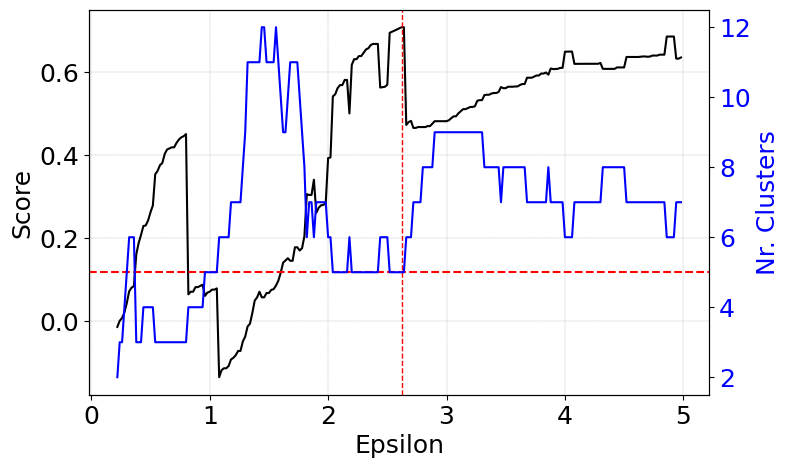

[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Create scatterplot
[clustimage] >INFO> Add transparency to RGB colors (last column)
[clusteval] >INFO> Add transparency to RGB colors (last column)
[clusteval] >INFO> Add density layer
[clusteval] >INFO> Create scatterplot


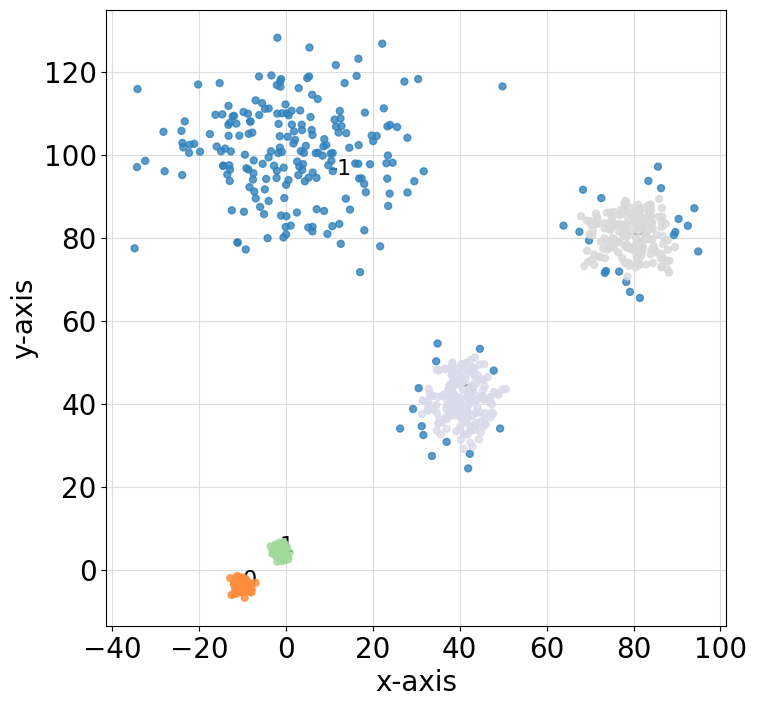

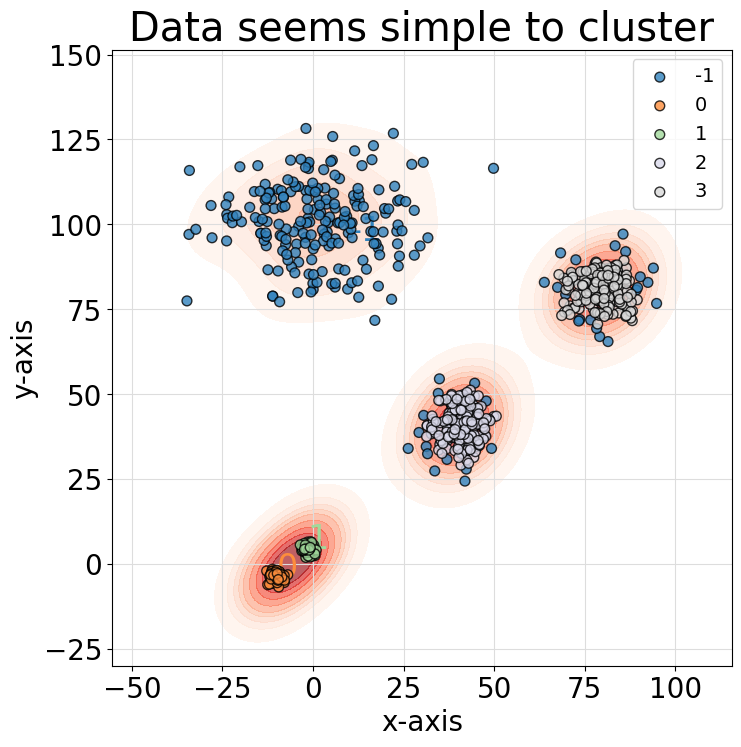

In [ ]:
# Cluster evaluation with silhouette score
# cl = clusteval(cluster='hdbscan', linkage='ward', metric='euclidean')
cl = clusteval(cluster='dbscan', linkage='ward', metric='euclidean')

cl_results=cl.fit(X2)
cl.plot(figsize=(8,5))

# scatter plot
cl.scatter(X2, figsize=(8, 8))

fig, ax = scatterd(X2[:,0],
        X2[:,1],
        s=50,
        labels=cl.results['labx'],
        density=True,
        gradient=None, #'#ffffff'
        title='Data seems simple to cluster',
        figsize=(8, 8),
        )

In [ ]:
# Fin